In [1]:
import numpy as np
import pypianoroll
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt
import pretty_midi
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import pygame
import os
import pickle
import subprocess

%matplotlib inline

import matplotlib

import seaborn as sns


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Parse a MIDI file to a `pypianoroll.Multitrack` instance

multitrack = Multitrack('./data/rock.mid')
for idx, track in enumerate(multitrack.tracks):
    pianoroll = track.pianoroll


#print (multitrack.beat_resolution,)
num_track = len(multitrack.tracks)
downbeats = multitrack.get_downbeat_steps()
#print (downbeats,num_track)

In [3]:
import mido
from mido import MidiFile, MidiTrack, Message
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import numpy as np

Using TensorFlow backend.


In [30]:
mid = MidiFile('data/rock.mid') 
notes = []

In [31]:
notes = []
for msg in mid:
    #print(msg)
    if not msg.is_meta and msg.channel == 9 and msg.type == 'note_on':
        data = msg.bytes()
        notes.append(data[1])

In [33]:
#notes

In [11]:

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(np.array(notes).reshape(-1,1))
notes = list(scaler.transform(np.array(notes).reshape(-1,1)))

In [12]:

# LSTM layers requires that data must have a certain shape
# create list of lists fist
notes = [list(note) for note in notes]

# subsample data for training and prediction
X = []
y = []
# number of notes in a batch
n_prev = 30
for i in range(len(notes)-n_prev):
    X.append(notes[i:i+n_prev])
    y.append(notes[i+n_prev])
# save a seed to do prediction later
X_test = X[-300:]
X = X[:-300]
y = y[:-300]

In [13]:
X

[[[0.0],
  [0.3783783783783784],
  [0.0],
  [0.43243243243243257],
  [0.0],
  [0.3783783783783784],
  [0.10810810810810811],
  [0.43243243243243257],
  [0.5945945945945946],
  [0.0],
  [0.3783783783783784],
  [0.0],
  [0.43243243243243257],
  [0.0],
  [0.3783783783783784],
  [0.10810810810810811],
  [0.43243243243243257],
  [0.5945945945945946],
  [0.0],
  [0.3783783783783784],
  [0.0],
  [0.43243243243243257],
  [0.0],
  [0.3783783783783784],
  [0.0],
  [0.43243243243243257],
  [0.0],
  [0.3783783783783784],
  [0.0],
  [0.43243243243243257]],
 [[0.3783783783783784],
  [0.0],
  [0.43243243243243257],
  [0.0],
  [0.3783783783783784],
  [0.10810810810810811],
  [0.43243243243243257],
  [0.5945945945945946],
  [0.0],
  [0.3783783783783784],
  [0.0],
  [0.43243243243243257],
  [0.0],
  [0.3783783783783784],
  [0.10810810810810811],
  [0.43243243243243257],
  [0.5945945945945946],
  [0.0],
  [0.3783783783783784],
  [0.0],
  [0.43243243243243257],
  [0.0],
  [0.3783783783783784],
  [0.0],
  

In [15]:
y

[[0.3783783783783784],
 [0.0],
 [0.43243243243243257],
 [0.43243243243243257],
 [0.3783783783783784],
 [0.0],
 [0.0],
 [0.43243243243243257],
 [0.0],
 [0.3783783783783784],
 [0.43243243243243257],
 [0.0],
 [0.0],
 [0.3783783783783784],
 [0.43243243243243257],
 [0.43243243243243257],
 [0.5945945945945946],
 [0.43243243243243257],
 [0.43243243243243257],
 [0.0],
 [0.3783783783783784],
 [0.43243243243243257],
 [0.43243243243243257],
 [0.43243243243243257],
 [0.3783783783783784],
 [0.891891891891892],
 [0.0],
 [0.43243243243243257],
 [0.0],
 [0.3783783783783784],
 [0.0],
 [0.43243243243243257],
 [0.0],
 [0.3783783783783784],
 [0.0],
 [0.43243243243243257],
 [0.0],
 [0.3783783783783784],
 [0.0],
 [0.43243243243243257],
 [0.0],
 [0.3783783783783784],
 [0.0],
 [0.43243243243243257],
 [0.0],
 [0.3783783783783784],
 [0.0],
 [0.43243243243243257],
 [0.0],
 [0.3783783783783784],
 [0.5945945945945946],
 [0.43243243243243257],
 [0.0],
 [0.43243243243243257],
 [0.3783783783783784],
 [0.0],
 [0.43243

In [18]:
model = Sequential()
model.add(LSTM(256, input_shape=(n_prev, 1), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(128, input_shape=(n_prev, 1), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(64, input_shape=(n_prev, 1), return_sequences=False))
model.add(Dropout(0.6))
model.add(Dense(1))
model.add(Activation('linear'))
optimizer = Adam(lr=0.001)
model.compile(loss='mse', optimizer=optimizer)
filepath="./Checkpoints/checkpoint_model_{epoch:02d}.hdf5"
model_save_callback = ModelCheckpoint(filepath, monitor='val_acc', 
                                      verbose=1, save_best_only=False, 
                                      mode='auto', period=5)

In [19]:
model.fit(np.array(X), np.array(y), 32, 5, verbose=1, callbacks=[model_save_callback])

Epoch 1/5
679/679 [==============================] - 4s 5ms/step - loss: 0.0761
Epoch 2/5
679/679 [==============================] - 3s 4ms/step - loss: 0.0560
Epoch 3/5
679/679 [==============================] - 3s 4ms/step - loss: 0.0549
Epoch 4/5
679/679 [==============================] - 2s 4ms/step - loss: 0.0572
Epoch 5/5
679/679 [==============================] - 3s 4ms/step - loss: 0.0515

Epoch 00005: saving model to ./Checkpoints/checkpoint_model_05.hdf5


In [20]:
prediction = model.predict(np.array(X_test))
prediction = np.squeeze(prediction)
prediction = np.squeeze(scaler.inverse_transform(prediction.reshape(-1,1)))
prediction = [int(i) for i in prediction]

In [23]:
mid = MidiFile()
track = MidiTrack()
t = 0
for note in prediction:
    # 147 means note_on
    # 67 is velosity
    note = np.asarray([147, note, 67])
    bytes = note.astype(int)
    msg = Message.from_bytes(bytes[0:3])
    t += 1
    msg.time = t
    track.append(msg)
mid.tracks.append(track)
mid.save('output/LSTM_music.mid')

In [24]:
from music21 import converter
melody = converter.parse("output/LSTM_music.mid")
melody.show('midi')

#showScore(melody)

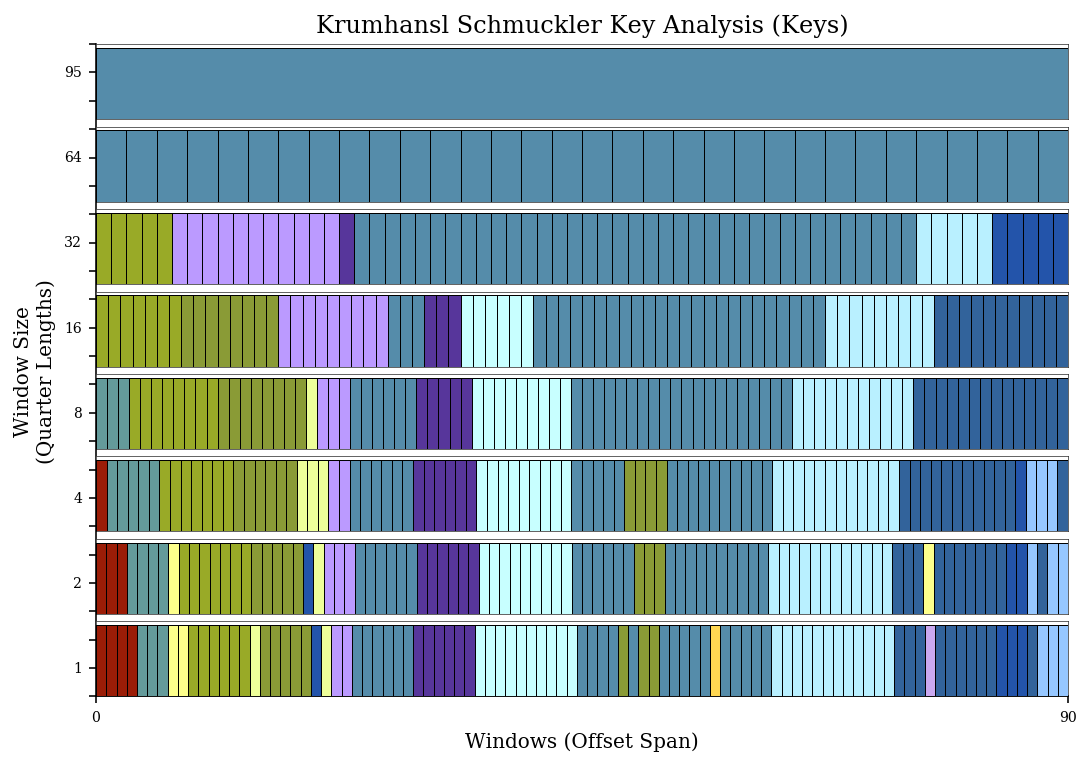

In [25]:
#https://ccrma.stanford.edu/~craig/papers/01/icmc01-harmony-2up.pdf
melody.plot('key')

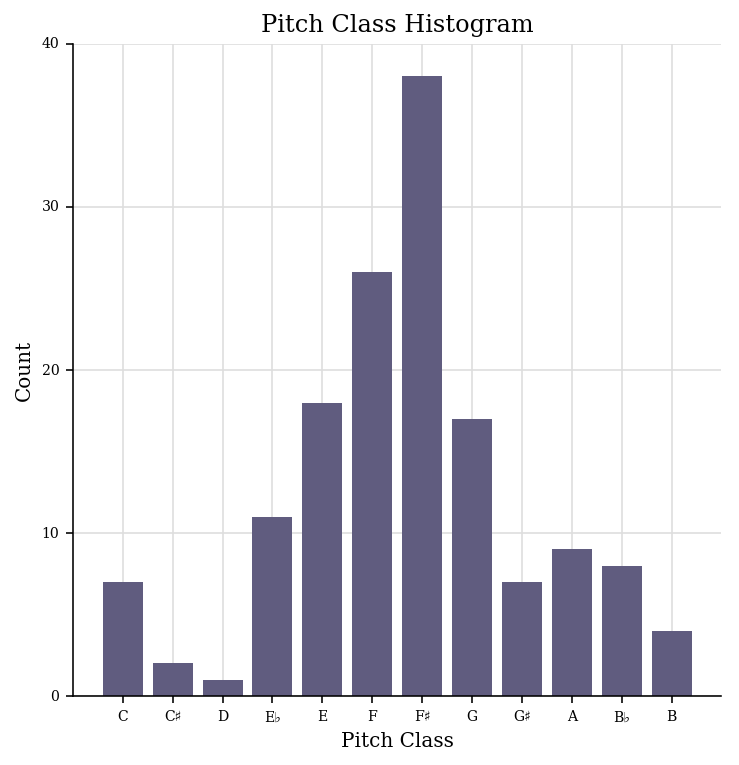

In [26]:
melody.plot('histogram', 'pitchClass')

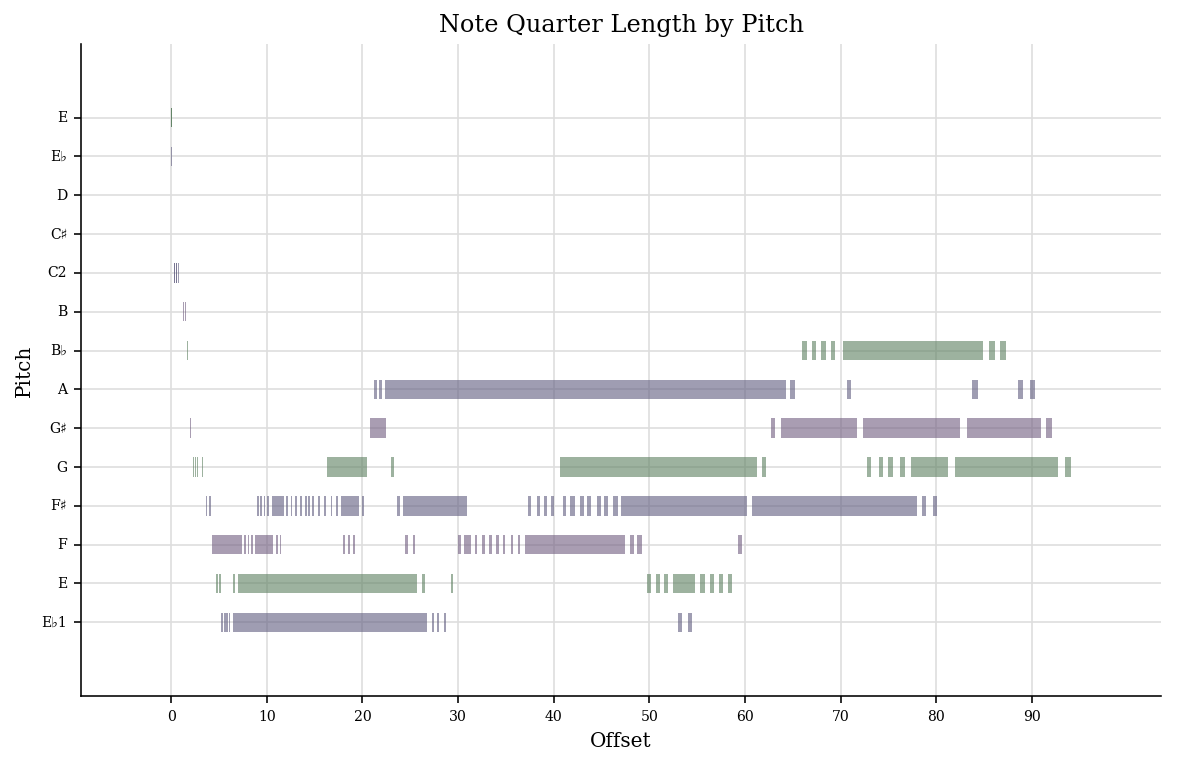

In [27]:
melody.plot()